# Object detection pipeline

This example shows a basic pipeline that performs object detection on a fragment of video.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import videoanalytics
import pandas as pd

In [3]:
from videoanalytics.pipeline import Pipeline
from videoanalytics.pipeline.sources import VideoReader
from videoanalytics.pipeline.sinks import VideoWriter
from videoanalytics.pipeline.sinks.transformation import Resizer
from videoanalytics.pipeline.sinks.object_detection.yolo4 import YOLOv4DetectorTF

In [4]:
DATA_PATH = "../data"

# Input
INPUT_VIDEO = DATA_PATH+"/test_video.mp4"
START_FRAME = 0
MAX_FRAMES = 10

# Detector

# Object Detector
DETECTOR_WEIGHTS_FILENAME = DATA_PATH+ "/checkpoints/yolov4-416-tf"

# Detections Annotator
DETECTOR_CLASSES_FILENAME = DATA_PATH+"/classes/coco.names"

# Output
OUTPUT_VIDEO = DATA_PATH+ "/output.mp4"

In [13]:
# 1. Create the global context
context = {}

# 2. Create the pipeline
pipeline = Pipeline()

# 3. Add components

# 3.1 Source
pipeline.add_component( VideoReader( "input",context,
                 video_path=INPUT_VIDEO,
                 start_frame=START_FRAME,
                 max_frames=MAX_FRAMES))

# 3.2 Resizer
pipeline.add_component( Resizer("resizer",context,output_w=416,output_h=416) )

# 3.3 Detector
pipeline.add_component( YOLOv4DetectorTF("detector",context,weights_filename=DETECTOR_WEIGHTS_FILENAME) )

# 3.3 Sink
pipeline.add_component(VideoWriter("writer",context,filename=OUTPUT_VIDEO))

  0%|          | 0/10 [00:00<?, ?it/s]

In [14]:
# 4. Define connections
pipeline.set_connections([
    ("input", "resizer"),
    ("resizer", "detector"),
    ("detector", "writer")
])

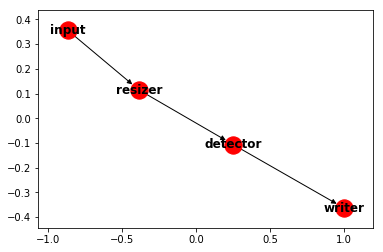

In [15]:
pipeline.optimize()
pipeline.plot()

In [16]:
# 5. Execute
pipeline.execute()

In [17]:
# 6. Report (optional)
metrics_df = pd.DataFrame.from_dict(pipeline.get_metrics(), orient='index',columns=["time [s]"])

In [18]:
metrics_df

,time [s]
input_avg_dt,0.007346
resizer_avg_dt,0.012200
detector_avg_dt,0.850811
writer_avg_dt,0.000181
